# Gaussian Process Overview:
Here we investigate how to fit a simple 1-D function using a Gaussian Process model using the versatile Python package PyMC.

In [213]:
import math

import numba
import numpy as np
import pymc as pm
from pymc.gp.util import plot_gp_dist
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed so result is reproducible
np.random.seed(1234)


### Define and visualize our test function:

Optima: x=0.900, y=0.829


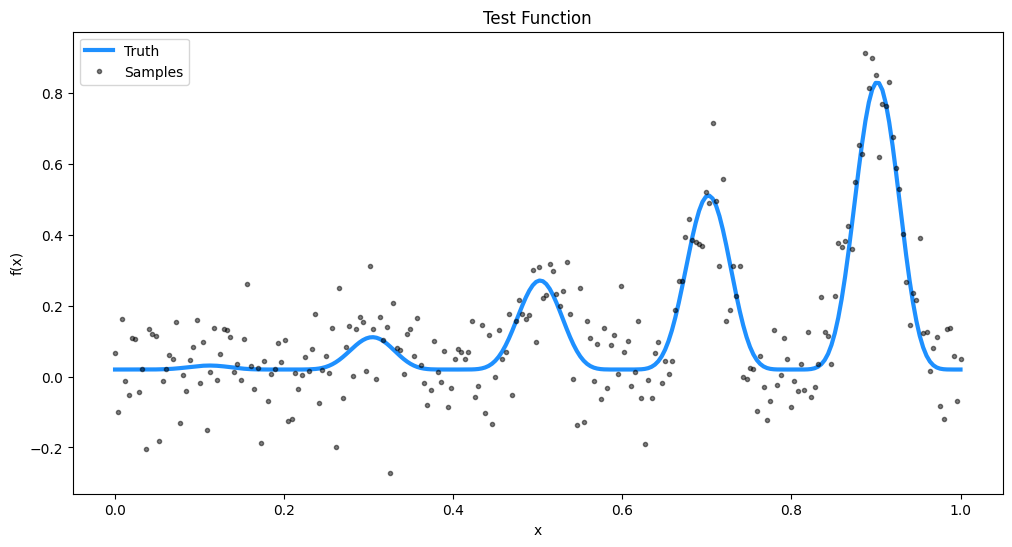

In [214]:
@numba.jit
def test_function(x, sigma=0.1):
    # Add some noise to make this function hard to optimize
    noise = np.random.normal(loc=0, scale=sigma)
    return (x**2 * np.sin(5 * np.pi * x)**6.0) + noise

# The number of data points
n = 250
# Samples of the domain [0,1]
# The inputs to the GP, they must be arranged as a column vector
X = np.linspace(0, 1, n).reshape(-1, 1)
# Sample the domain without noise
f_true = test_function(X).flatten()
# Add some noise
sigma_true = 0.1
f_noise = f_true + sigma_true * np.random.randn(n).flatten()
# find best result
ix = np.argmax(f_true)
print('Optima: x=%.3f, y=%.3f' % (X[ix], f_true[ix]))
fig = plt.figure(figsize=(12, 6))
ax = fig.gca()
# Plot the points without noise
ax.plot(X, f_true, "dodgerblue", lw=3, label="Truth")
# Plot the points with noise
ax.plot(X, f_noise, "ok", ms=3, alpha=0.5, label="Samples")
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
plt.title("Test Function")
plt.legend()
plt.show()

### Define the Gaussian Process model with PyMC:
Because the paper we are interested in replicating uses the ARD Matern 5/2 kernel, we will do the same. 

In [215]:
# Define PyMC model
model = pm.Model()
with model:
    # The paper doesn't specify the distributions for theta/theta0. Here we choose Gamma based on sklearns implementation and other online articles.
    # SEE: https://www.dominodatalab.com/blog/fitting-gaussian-process-models-python
    # SEE: https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html#sklearn.gaussian_process.kernels.Matern
    theta = pm.Gamma("ls", alpha=2, beta=1)
    theta0 = pm.HalfCauchy("theta0", beta=5)
    cov = theta0**2 * pm.gp.cov.Matern52(input_dim=1, ls=1.0)
    # Zero mean (redundant - this is the default)
    m = pm.gp.mean.Zero()
    # Observation noise r.v.
    sigma = pm.HalfCauchy("sigma", beta=5)
    # Create the Gaussian Process, here we use the Marginal implementation
    gp = pm.gp.Marginal(mean_func=m, cov_func=cov)
    y_ = gp.marginal_likelihood("f", X=X, y=f_noise, sigma=sigma)
    mp = pm.find_MAP(progressbar=False)

### Make some predictions using the posterior

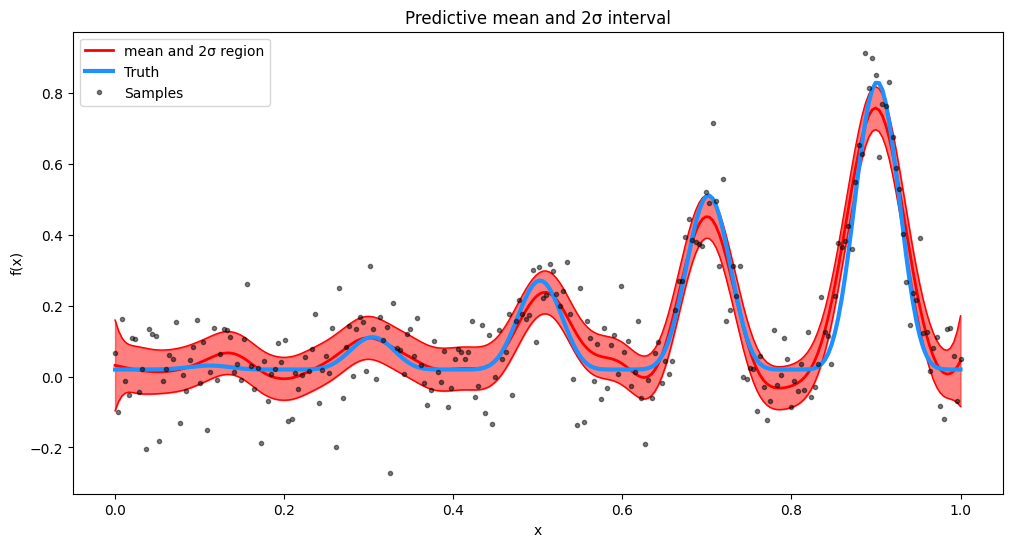

In [216]:
mu, var = gp.predict(X, point=mp, diag=True, model=model)
sd = np.sqrt(var)

fig = plt.figure(figsize=(12, 6))
ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X, mu, "r", lw=2, label="mean and 2σ region")
plt.plot(X, mu + 2 * sd, "r", lw=1)
plt.plot(X, mu - 2 * sd, "r", lw=1)
plt.fill_between(X.flatten(), mu - 2 * sd, mu + 2 * sd, color="r", alpha=0.5)

# Plot the original data and samples
ax.plot(X, f_true, "dodgerblue", lw=3, label="Truth")
ax.plot(X, f_noise, "ok", ms=3, alpha=0.5, label="Samples")
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
plt.title("Predictive mean and 2σ interval")
plt.legend()


# Regression with White, Gaussian Noise

### Define and visualize the function + data samples

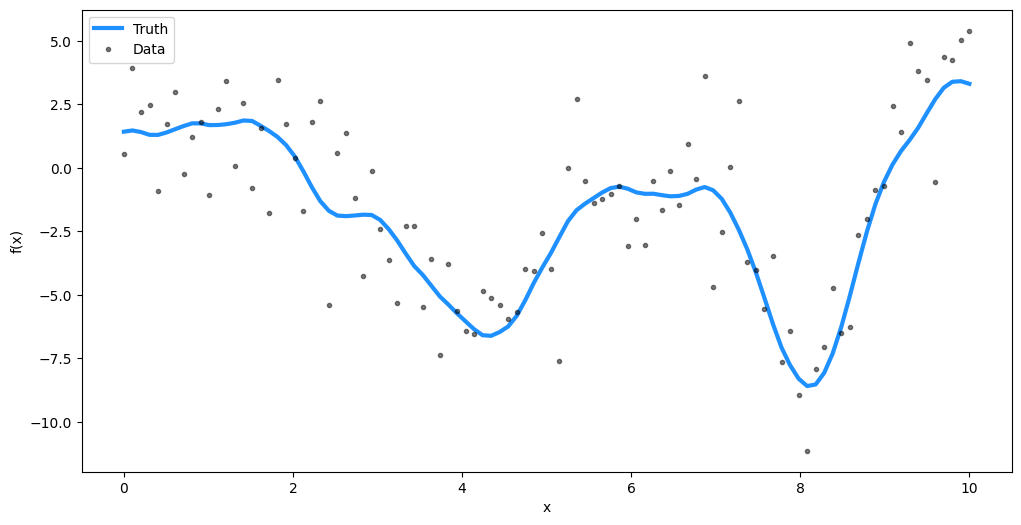

In [217]:
# set the seed
np.random.seed(1)

n = 100  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true ** 2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 6))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="Truth")
ax.plot(X, y, "ok", ms=3, alpha=0.5, label="Data")
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
plt.legend()

### Define the Gaussian Process model with PyMC:

In [218]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, sigma=σ)

    mp = pm.find_MAP(progressbar=False)

### Make some predictions using the Posterior:

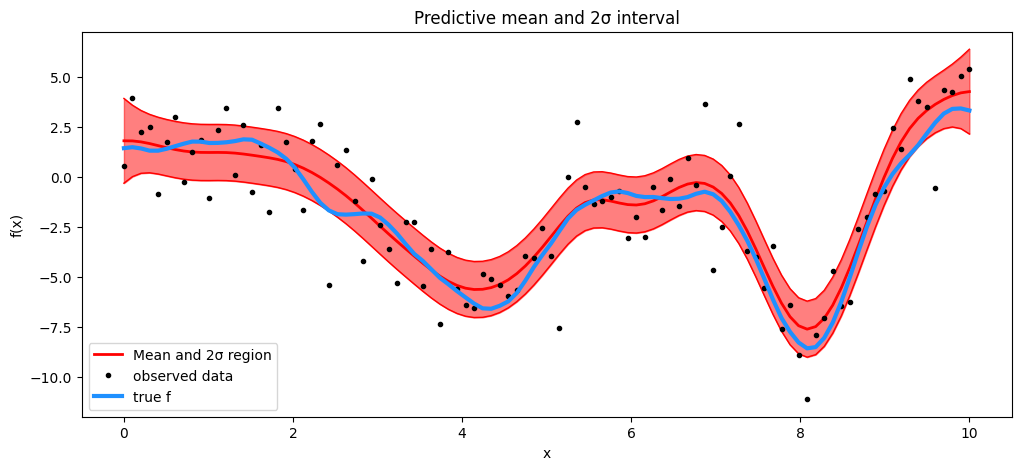

In [219]:
mu, var = gp.predict(X, point=mp, diag=True, model=model)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X, mu, "r", lw=2, label="Mean and 2σ region")
plt.plot(X, mu + 2 * sd, "r", lw=1)
plt.plot(X, mu - 2 * sd, "r", lw=1)
plt.fill_between(X.flatten(), mu - 2 * sd, mu + 2 * sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, "ok", ms=3, alpha=1.0, label="observed data")
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")

plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Predictive mean and 2σ interval")
plt.legend()